<a href="https://colab.research.google.com/github/MouliChintakunta-AI/DLTutors/blob/main/Generalised_Input_vectorisation_with_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,log_loss
from sklearn.datasets import make_blobs,make_moons
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(0)

In [85]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)

In [5]:
data,labels = make_blobs(n_samples=1000,n_features = 2,centers = 4,random_state = 9)

In [6]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",colors=['red','green','blue','orange','violet'])

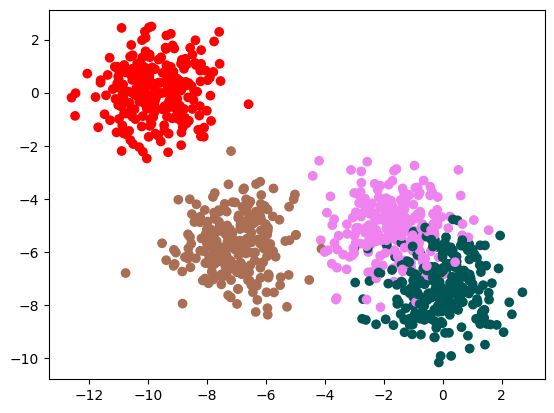

In [7]:
plt.scatter(data[:,0],data[:,1],c = labels,cmap=my_cmap)

In [69]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,stratify = labels,random_state = 10)

In [9]:
lb = LabelBinarizer()
Y_train_oh = lb.fit_transform(Y_train)

In [10]:
Y_train_oh.shape

(750, 4)

In [14]:
class GeneralisedBackpropagation:
  def __init__(self,W1,W2):
    self.W1 = W1
    self.W2 = W2
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))

  def grad_sigmoid(self,X):
    return X*(1-X)

  def sigmoid(self,X):
    return 1.0 / (1.0 + np.exp(-X))

  def softmax(self,X):
    exp = np.exp(X)
    return exp/np.sum(exp,axis = 1).reshape(-1,1)

  def forward_pass(self,X):
    self.A1 = np.matmul(X,self.W1) + self.B1
    self.H1 = self.sigmoid(self.A1)
    self.A2 = np.matmul(self.A1,self.W2) + self.B2
    self.H2 = self.softmax(self.A2)
    return self.H2

  def grad(self,X,Y):
    self.forward_pass(X)
    self.dA2 = self.H2 - Y
    self.dW2 = np.matmul(self.H1.T,self.dA2)
    self.dB2 = np.sum(self.dA2,axis = 0).reshape(1,-1)
    self.dH1 = np.matmul(self.dA2,self.W2.T)
    self.dA1 = np.multiply(self.dH1,self.grad_sigmoid(self.H1))
    self.dW1 = np.matmul(X.T,self.dA1)
    self.dB1 = np.sum(self.dA1,axis=0).reshape(1,-1)

  def fit(self,X,Y,epochs= 2000,learning_rate = 0.3,display_loss = True):
    if display_loss:
      loss={}
    for epoch in tqdm_notebook(range(epochs),desc = "Training Vectorized",unit = 'Epoch'):
      self.grad(X,Y)
      m = X.shape[0]
      self.W1 -= learning_rate *( self.dW1/m)
      self.B1 -= learning_rate *( self.dB1/m)
      self.W2 -= learning_rate *( self.dW2/m)
      self.B2 -= learning_rate *( self.dB2/m)
      if display_loss:
        y_pred = self.predict(X)
        loss[epoch] = log_loss(Y,y_pred)
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel("Epochs")
      plt.ylabel("Log-Loss")
      plt.show()

  def predict(self,X):
    return self.forward_pass(X).squeeze()

<ipython-input-14-a1eeb2e42e73>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),desc = "Training Vectorized",unit = 'Epoch'):


Training Vectorized:   0%|          | 0/2000 [00:00<?, ?Epoch/s]

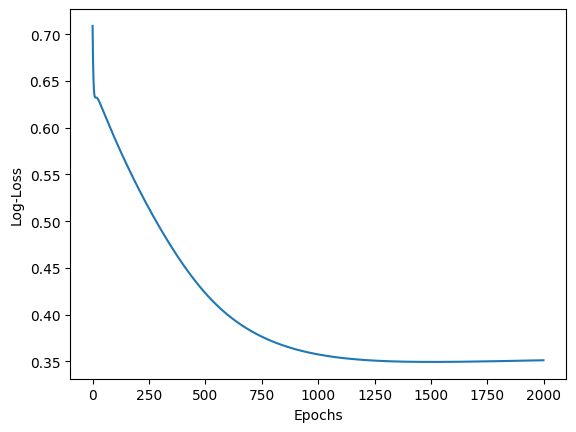

In [88]:
model = GeneralisedBackpropagation(W1,W2)
model.fit(X_train,Y_train_oh,epochs = 2000, learning_rate = .06)

In [89]:
y_train_pred = model.predict(X_train)
y_train = np.argmax(y_train_pred,1)
y_train_accuracy_score =accuracy_score(y_train,Y_train)
print("Training Accuracy:",y_train_accuracy_score)
y_test_pred = model.predict(X_test)
y_test = np.argmax(y_test_pred,1)
y_test_accuracy_score =accuracy_score(y_test,Y_test)
print("Testing Accuracy:",y_test_accuracy_score)

Training Accuracy: 0.892
Testing Accuracy: 0.908


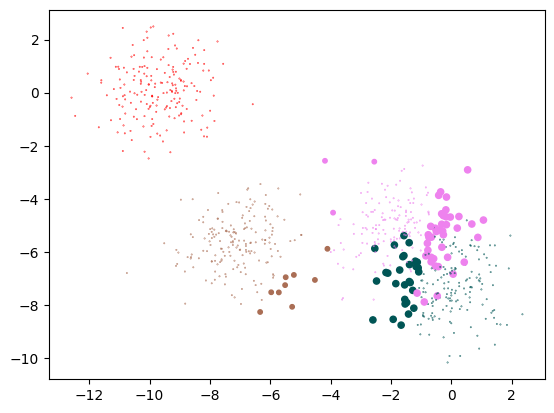

In [90]:
plt.scatter(X_train[:,0],X_train[:,1],c= Y_train,cmap= my_cmap,s = 10* np.abs(y_train - Y_train)+.1)

In [105]:
class GenericVectorizer:

  def __init__(self,n_inputs,n_outputs,hidden=[2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden)
    self.sizes = [self.nx] + hidden + [self.ny] # [2 2 4]
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i],self.sizes[i+1])
      self.B[i+1] = np.zeros((1,self.sizes[i+1]))
  def sigmoid(self,X):
    return 1.0 / (1.0+np.exp(-X))

  def grad_sigmoid(self,X):
    return X * (1-X)

  def softmax(self,X):
    exp = np.exp(X)
    return exp/np.sum(exp,axis=1).reshape(-1,1)

  def forward_pass(self,X):
    self.A ={}
    self.H ={}
    self.H[0] = X
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i],self.W[i+1]) + self.B[i+1]
      if self.ny == 1 or i < self.nh:
        self.H[i+1] = self.sigmoid(self.A[i+1])
      else:
        self.H[i+1] = self.softmax(self.A[i+1])
    return self.H[self.nh+1]

  def grad(self,X,Y):
    self.forward_pass(X)
    self.dW = {}
    self.dB = {}
    self.dA = {}
    self.dH = {}
    L = self.nh+1
    self.dA[L] = self.H[L] - Y
    for k in range(L,0,-1):
      self.dW[k] = np.matmul(self.H[k-1].T,self.dA[k])
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
      self.dH[k-1] = np.matmul(self.dA[k],self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1],self.grad_sigmoid(self.H[k-1]))

  def fit(self,X,Y,epochs= 2000,learning_rate=1e-3,display_loss=True):
    if display_loss:
      loss={}
    for epoch in tqdm_notebook(range(epochs),desc="Training Final one",unit='Epoch'):
      self.grad(X,Y)
      m = X.shape[0]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (self.dW[i+1]/m)
        self.B[i+1] -= learning_rate * (self.dB[i+1]/m)
      if display_loss:
        y_pred = self.predict(X)
        loss[epoch] = log_loss(Y,y_pred)
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel("Epochs")
      plt.ylabel("Log-Loss")
      plt.show()

  def predict(self,X):
    y_pred = self.forward_pass(X)
    return y_pred.squeeze()


<ipython-input-105-d9eb328c372e>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),desc="Training Final one",unit='Epoch'):


Training Final one:   0%|          | 0/2000 [00:00<?, ?Epoch/s]

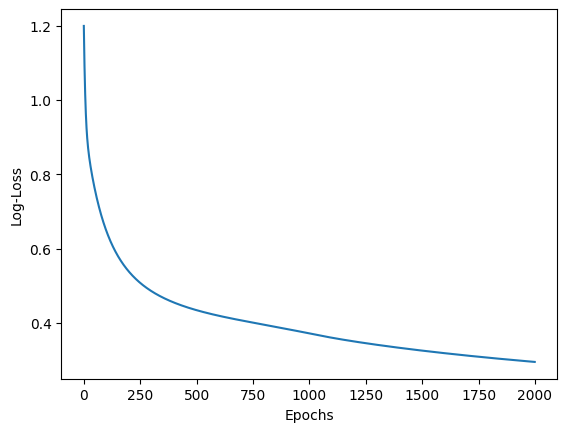

In [120]:
final_model = GenericVectorizer(n_inputs = 2,n_outputs=4,hidden=[4,8,2])
final_model.fit(X_train,Y_train_oh,learning_rate=.2)

In [121]:
y_train_pred = final_model.predict(X_train)
y_train = np.argmax(y_train_pred,1)
y_train_accuracy_score =accuracy_score(y_train,Y_train)
print("Training Accuracy:",y_train_accuracy_score)
y_test_pred = final_model.predict(X_test)
y_test = np.argmax(y_test_pred,1)
y_test_accuracy_score =accuracy_score(y_test,Y_test)
print("Testing Accuracy:",y_test_accuracy_score)

Training Accuracy: 0.9106666666666666
Testing Accuracy: 0.904


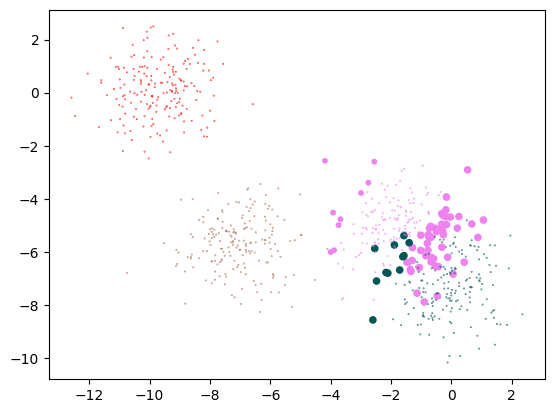

In [122]:
plt.scatter(X_train[:,0],X_train[:,1],c= Y_train,cmap= my_cmap,s = 10* np.abs(y_train - Y_train)+.1)

<ipython-input-105-d9eb328c372e>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),desc="Training Final one",unit='Epoch'):


Training Final one:   0%|          | 0/2000 [00:00<?, ?Epoch/s]

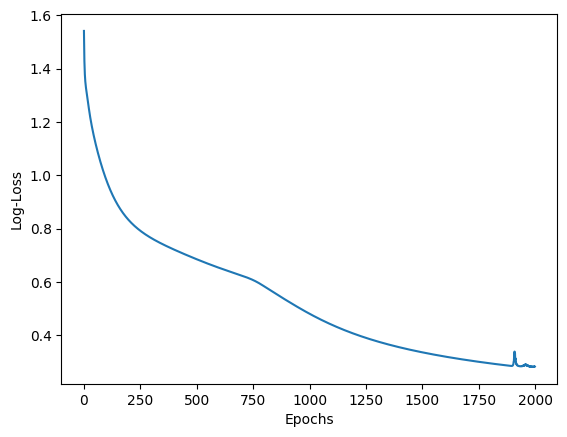

In [124]:
final_model1 = GenericVectorizer(n_inputs = 2,n_outputs=4,hidden=[4,8,2])
final_model1.fit(X_train,Y_train_oh,learning_rate=.2)

In [125]:
y_train_pred = final_model1.predict(X_train)
y_train = np.argmax(y_train_pred,1)
y_train_accuracy_score =accuracy_score(y_train,Y_train)
print("Training Accuracy:",y_train_accuracy_score)
y_test_pred = final_model1.predict(X_test)
y_test = np.argmax(y_test_pred,1)
y_test_accuracy_score =accuracy_score(y_test,Y_test)
print("Testing Accuracy:",y_test_accuracy_score)

Training Accuracy: 0.9266666666666666
Testing Accuracy: 0.916


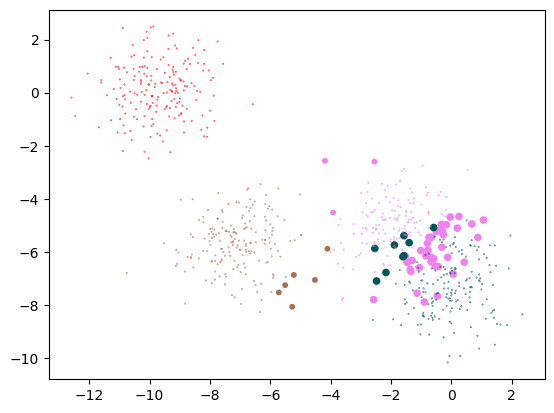

In [126]:
plt.scatter(X_train[:,0],X_train[:,1],c= Y_train,cmap= my_cmap,s = 10* np.abs(y_train - Y_train)+.1)